In [1]:
import cv2 as cv
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.exposure import histogram
from matplotlib.pyplot import bar
from scipy import ndimage as ndi
import skimage


In [2]:
def show_images(images, titles=None):
    # This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()


# def iterative_threshold(img):
#     print("here")
#     print(img.shape)

#     # Initialize the threshold value to 127
#     # Set the initial threshold value
#     threshold_value = 128

#     # Set the maximum number of iterations
#     max_iterations = 10

#     # Perform iterative thresholding
#     while True:
#         # Threshold the image
#         _, thresholded = cv2.threshold(
#             img, threshold_value, 255, cv2.THRESH_BINARY)

#         # Calculate the mean of the pixels in the object region
#         object_mean = cv2.mean(img, thresholded)[0]

#         # Calculate the mean of the pixels in the background region
#         background_mean = cv2.mean(img, ~thresholded)[0]

#         # Update the threshold value using Otsu's method
#         new_threshold_value = int((object_mean + background_mean) / 2)

#         # Check if the new threshold value is the same as the current threshold value
#         if new_threshold_value == threshold_value:
#             break

#         # Update the threshold value and loop again
#         threshold_value = new_threshold_value
#     img[img < thresh] = 0
#     return img

def iterative_threshold(image):
    # Set initial threshold value
    thresh = np.mean(image)

    # Set initial threshold difference value
    diff = 10

    # Loop until threshold difference falls below 1
    while diff > 1:
        # Threshold the image
        _, thresh_img = cv2.threshold(image, thresh, 255, cv2.THRESH_BINARY)

        # Calculate the mean pixel values on either side of the threshold
        mean_low = np.mean(image[thresh_img == 0])
        mean_high = np.mean(image[thresh_img == 255])

        # Update the threshold value
        new_thresh = (mean_low + mean_high) / 2
        diff = abs(thresh - new_thresh)
        thresh = new_thresh

    # Return the thresholded image
    return thresh_img

def showHist(img):
    # An "interface" to matplotlib.axes.Axes.hist() method
    plt.figure()
    imgHist = histogram(img, nbins=256)

    bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align='center')


def fill_holes(image):
    # Copy the input image
    im_floodfill = image.copy()

    # Mask used to flood filling.
    # Notice the size needs to be 2 pixels larger than the input image.
    h, w = image.shape[:2]
    mask = np.zeros((h+2, w+2), dtype=np.uint8)

    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (0, 0), 255)

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    filled_image = image | im_floodfill_inv

    return filled_image


def binary_threshold(image, threshold_value):
    # Apply binary thresholding
    ret, binary = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)

    return binary


def find_first_peak(img):
    imgHist = histogram(img, nbins=256)
    # Find the indices of all local maxima
    peak_indices = np.where(np.diff(np.sign(np.diff(imgHist))) == -2)[0] + 1
    # Return the index of the first peak
    return peak_indices[0] if len(peak_indices) > 0 else None


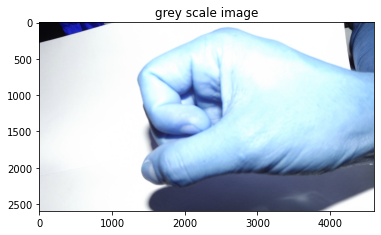

In [3]:
# Read image
img = cv.imread('../Dataset_0-5/men/0/0_men (27).JPG')
show_images(images=[img],titles=["grey scale image"])


## Solution using HSV (Worst)

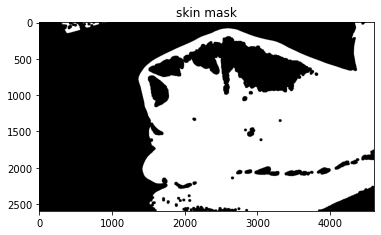

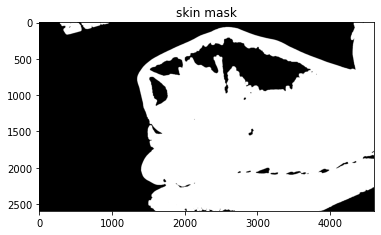

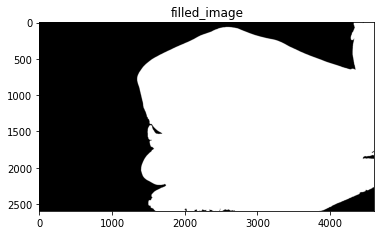

In [4]:
lower = np.array([0, 20, 70], dtype=np.uint8)
upper = np.array([50, 255, 255], dtype=np.uint8)
converted = cv.cvtColor(img, cv.COLOR_BGR2HSV)
skinMask = cv.inRange(converted, lower, upper)
# apply a series of erosions and dilations to the mask
# using an elliptical kernel
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (20, 20))
skinMask = cv.erode(skinMask, kernel, iterations=2)
show_images(images=[skinMask], titles=["skin mask"])
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (20, 20))
skinMask = cv.dilate(skinMask, kernel, iterations=2)

show_images(images=[skinMask],titles=["skin mask"])

# Find the contours in the binary image
# binary_ycrcb_image_inv = cv.bitwise_not(binary_ycrcb_image)
binary_ycrcb_image_inv = skinMask.copy()

contours, hierarchy = cv.findContours(
    binary_ycrcb_image_inv, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Get the contour with the largest area
largest_contour = max(contours, key=cv.contourArea)

# Create a blank image to draw and fill the contours
largest_contour_image = np.zeros_like(binary_ycrcb_image_inv)
# Draw the largest contour on the image
cv.drawContours(largest_contour_image, [largest_contour], 0, ( 255, 255), -1)


show_images([largest_contour_image], ["filled_image"])


## Solution using ycrcb (2nd best)

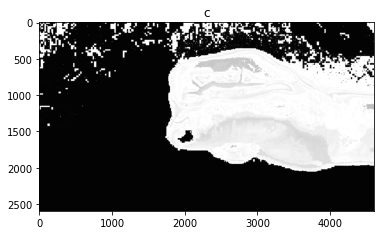

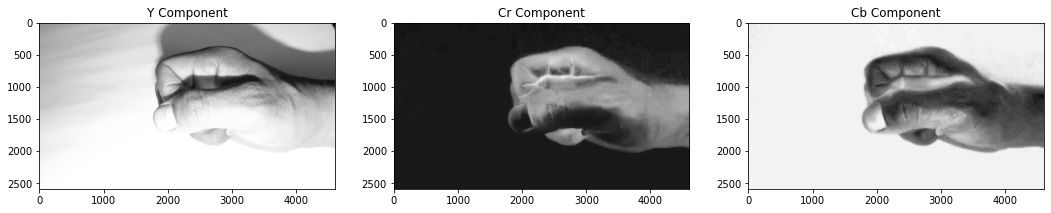

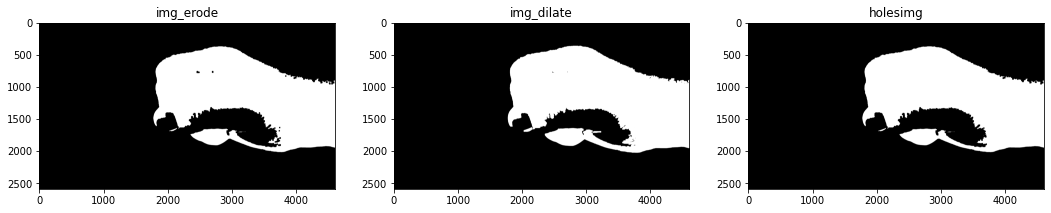

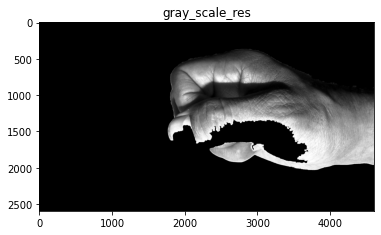

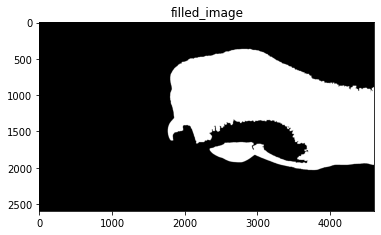

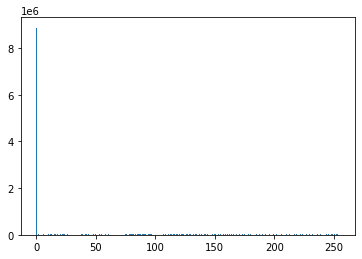

In [14]:
img = cv.imread('../Dataset_0-5/men/0/0_men (1).JPG')

# rgb_planes = cv2.split(img)

# gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# first_peak = find_first_peak(gray_img)
# print(first_peak)
# showHist(gray_img)

# result_planes = []
# for plane in rgb_planes:
#     plane[gray_img < 80] = 255
#     result_planes.append(plane)
# img = cv.merge(result_planes)

# Convert the input image to YCrCb color space
ycrcb_image = cv.cvtColor(img, cv.COLOR_BGR2YCrCb)



# Define the lower and upper bounds of the skin color in YCrCb color space
lower_skin = np.array([0, 133, 77])
upper_skin = np.array([255, 180, 150])

# Apply the color segmentation using cv2.inRange()
binary_ycrcb_image = cv.inRange(ycrcb_image, lower_skin, upper_skin)

# show_images([binary_ycrcb_image], ["threshold ycrcb"])

# Extract the individual color components
y, cr, cb = cv.split(ycrcb_image)

show_images([cv.bitwise_or(cr, cb)],"cr cb or")
# Show the individual color components
show_images([y, cr, cb], ['Y Component', 'Cr Component', 'Cb Component'])

kernel = np.ones((20, 20), np.uint8)

img_erode = cv.erode(binary_ycrcb_image, kernel, iterations=1)

holesimg = ndi.binary_fill_holes(img_erode).astype(int)

kernel = np.ones((20, 20), np.uint8)

img_dilate = cv.dilate(img_erode, kernel, iterations=1)
# # Perform morphological closing to fill small holes
# kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
# closed_img = cv.morphologyEx(binary_ycrcb_image, cv.MORPH_CLOSE, kernel)

# # Perform morphological opening to remove large holes
# kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (20, 20))
# opened_img = cv.morphologyEx(closed_img, cv.MORPH_OPEN, kernel)

show_images([img_erode, img_dilate, holesimg], ["img_erode", "img_dilate", "holesimg"])


# Find the contours in the binary image
# binary_ycrcb_image_inv = cv.bitwise_not(binary_ycrcb_image)
binary_ycrcb_image_inv = img_dilate.copy()

contours, hierarchy = cv.findContours(
    binary_ycrcb_image_inv, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Get the contour with the largest area
largest_contour = max(contours, key=cv.contourArea)

# Create a blank image to draw and fill the contours
largest_contour_image_ycrcb = np.zeros_like(binary_ycrcb_image_inv)
# Draw the largest contour on the image
cv.drawContours(largest_contour_image_ycrcb, [
                largest_contour], 0, ( 255, 255), -1)


gray_scale_res = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray_scale_res[largest_contour_image_ycrcb == 0] = 0
gray_scale_res = cv.equalizeHist(gray_scale_res)


show_images([cv.equalizeHist(gray_scale_res)], ["gray_scale_res"])
show_images([largest_contour_image_ycrcb], ["filled_image"])

showHist(gray_scale_res)


## BEST BEST

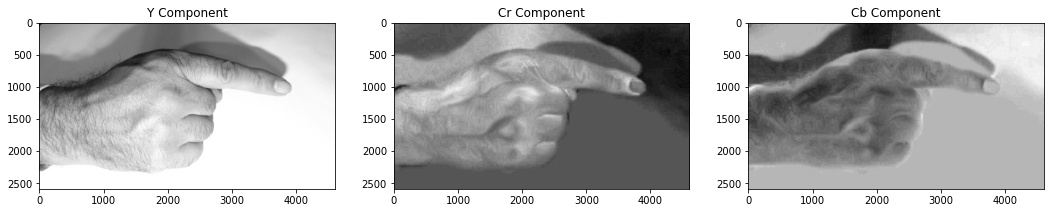

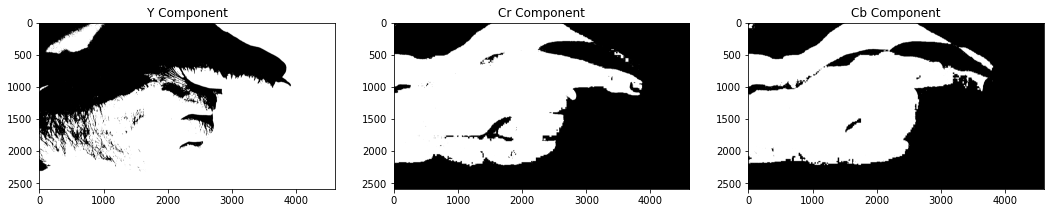

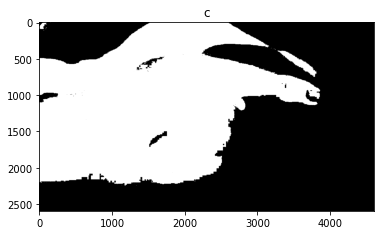

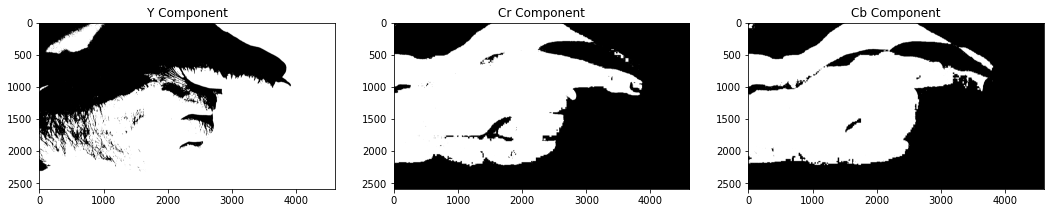

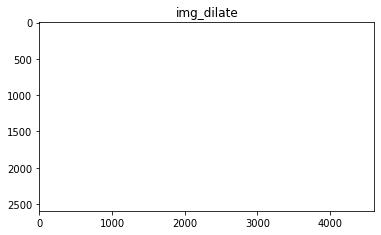

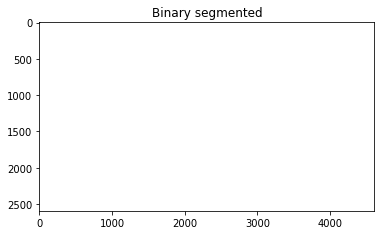

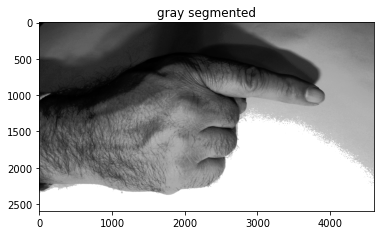

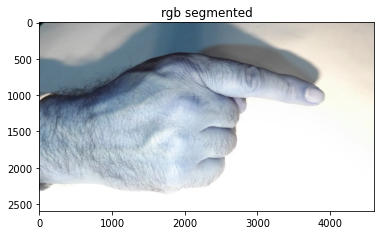

In [8]:
img = cv.imread('../Dataset_0-5/men/1/1_men (64).JPG')

# Convert the input image to YCrCb color space
ycrcb_image = cv.cvtColor(img, cv.COLOR_BGR2YCrCb)

# Extract the individual color components
y, cr, cb = cv.split(ycrcb_image)
show_images([y, cr, cb], ['Y Component', 'Cr Component', 'Cb Component'])

_, cr = cv.threshold(cr, 0, 255, cv.THRESH_OTSU)
_,cb = cv.threshold(cb, 0, 255, cv.THRESH_OTSU)
cb = 255-cb
_,y = cv.threshold(y, 0, 255, cv.THRESH_OTSU)
show_images([y, cr, cb], ['Y Component', 'Cr Component', 'Cb Component'])

# cr = fill_holes(cr)
# cb = fill_holes(cb)
# show_images([cr, cb], ['Cr fillholes', 'Cb fillholes'])

cr_or_cb = cv.bitwise_or(cr, cb)
show_images([cr_or_cb], "cr_or_cb")
show_images([y, cr, cb],['Y Component', 'Cr Component', 'Cb Component'])

# Erode
kernel = np.ones((10, 10), np.uint8)
img_erode = cv.erode(cr_or_cb, kernel, iterations=2)

# Fill holes
holesimg = fill_holes(img_erode)

# Dilate
kernel = np.ones((20, 20), np.uint8)
img_dilate = cv.dilate(holesimg, kernel, iterations=3)

img_dilate = fill_holes(img_dilate)

show_images([img_dilate],["img_dilate"])

# Get the contour with the largest area
contours, hierarchy = cv.findContours(
    img_dilate, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv.contourArea)
largest_contour_image_cr_or_cb = np.zeros_like(cr_or_cb)
cv.drawContours(largest_contour_image_cr_or_cb, [
                largest_contour], 0, (255, 255), -1)


gray_scale_res_cr_or_cb = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray_scale_res_cr_or_cb[largest_contour_image_cr_or_cb == 0] = 0
gray_scale_res_cr_or_cb = cv.equalizeHist(gray_scale_res_cr_or_cb)

show_images([largest_contour_image_cr_or_cb], ["Binary segmented"])
show_images([cv.equalizeHist(gray_scale_res_cr_or_cb)], ["gray segmented"])


rgb_planes = cv2.split(img)
result_planes = []
for plane in rgb_planes:
    plane[largest_contour_image_cr_or_cb == 0] = 0
    result_planes.append(plane)
rgb_segmented = cv.merge(result_planes)

show_images([rgb_segmented],["rgb segmented"])



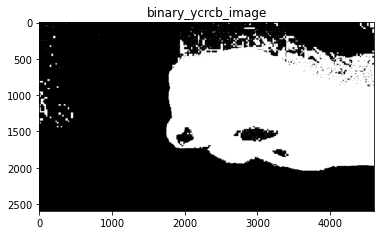

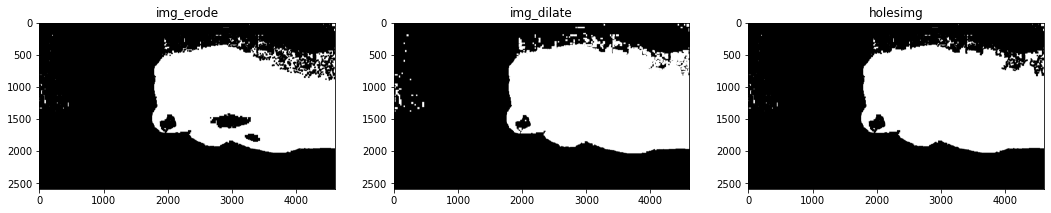

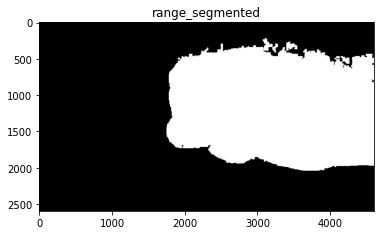

In [40]:
def range_segmentation(img):
    # Convert the input image to YCrCb color space
    ycrcb_image = cv.cvtColor(img, cv.COLOR_BGR2YCrCb)

    # Define the lower and upper bounds of the skin color in YCrCb color space
    lower_skin = np.array([0, 129, 70])
    upper_skin = np.array([255, 180, 150])

    # Apply the color segmentation using cv2.inRange()
    binary_ycrcb_image = cv.inRange(ycrcb_image, lower_skin, upper_skin)

    show_images([binary_ycrcb_image], ["binary_ycrcb_image"])

    kernel = np.ones((20, 20), np.uint8)
    img_erode = cv.erode(binary_ycrcb_image, kernel, iterations=1)

    holesimg = fill_holes(img_erode)

    kernel = np.ones((20, 20), np.uint8)
    img_dilate = cv.dilate(holesimg, kernel, iterations=1)

    show_images([img_erode, img_dilate, holesimg], ["img_erode", "img_dilate", "holesimg"])


    # Find the contours in the binary image
    binary_ycrcb_image_inv = img_dilate.copy()

    contours, hierarchy = cv.findContours(
        binary_ycrcb_image_inv, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Get the contour with the largest area
    largest_contour = max(contours, key=cv.contourArea)

    # Create a blank image to draw and fill the contours
    largest_contour_image_ycrcb = np.zeros_like(binary_ycrcb_image_inv)
    # Draw the largest contour on the image
    cv.drawContours(largest_contour_image_ycrcb, [
                    largest_contour], 0, ( 255, 255), -1)

    return largest_contour_image_ycrcb

def cr_or_cb_segmentation(img):
    range_segmented_image = range_segmentation(img)

    # Convert the input image to YCrCb color space
    ycrcb_image = cv.cvtColor(img, cv.COLOR_BGR2YCrCb)

    # Extract the individual color components
    y, cr, cb = cv.split(ycrcb_image)
    show_images([y, cr, cb], ['Y Component', 'Cr Component', 'Cb Component'])

    _, cr = cv.threshold(cr, 0, 255, cv.THRESH_OTSU)
    _, cb = cv.threshold(cb, 0, 255, cv.THRESH_OTSU)
    cb = 255-cb
    _, y = cv.threshold(y, 0, 255, cv.THRESH_OTSU)
    show_images([y, cr, cb], ['Y Component', 'Cr Component', 'Cb Component'])

    cr_or_cb = cv.bitwise_or(cr, cb)
    show_images([cr_or_cb], "cr_or_cb")
    show_images([y, cr, cb], ['Y Component', 'Cr Component', 'Cb Component'])

    # Erode
    kernel = np.ones((10, 10), np.uint8)
    img_erode = cv.erode(cr_or_cb, kernel, iterations=2)

    # Fill holes
    holesimg = fill_holes(img_erode)

    # Dilate
    kernel = np.ones((20, 20), np.uint8)
    img_dilate = cv.dilate(holesimg, kernel, iterations=3)

    img_dilate = fill_holes(img_dilate)

    show_images([img_dilate], ["img_dilate"])

    # Get the contour with the largest area
    contours, hierarchy = cv.findContours(
        img_dilate, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv.contourArea)
    largest_contour_image_cr_or_cb = np.zeros_like(cr_or_cb)
    cv.drawContours(largest_contour_image_cr_or_cb, [
                    largest_contour], 0, (255, 255), -1)


    gray_scale_res_cr_or_cb = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    gray_scale_res_cr_or_cb[largest_contour_image_cr_or_cb == 0] = 0
    gray_scale_res_cr_or_cb = cv.equalizeHist(gray_scale_res_cr_or_cb)

    show_images([largest_contour_image_cr_or_cb], ["Binary segmented"])
    show_images([cv.equalizeHist(gray_scale_res_cr_or_cb)], ["gray segmented"])


    rgb_planes = cv2.split(img)
    result_planes = []
    for plane in rgb_planes:
        plane[largest_contour_image_cr_or_cb == 0] = 0
        result_planes.append(plane)
    rgb_segmented = cv.merge(result_planes)

    show_images([rgb_segmented], ["rgb segmented"])


img = cv.imread('../Dataset_0-5/men/0/0_men (1).JPG')
range_segmented = range_segmentation(img)
show_images([range_segmented],["range_segmented"])


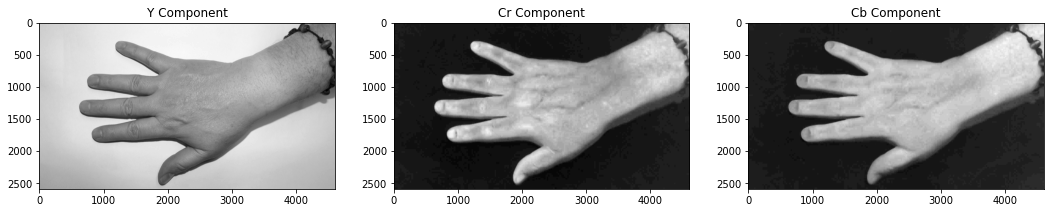

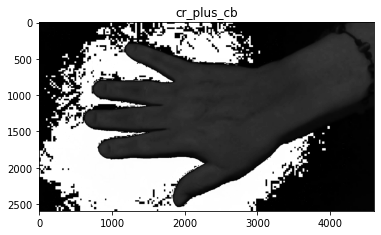

In [5]:
img = cv.imread('../Dataset_0-5/men/5/5_men (125).JPG')

# Convert the input image to YCrCb color space
ycrcb_image = cv.cvtColor(img, cv.COLOR_BGR2YCrCb)

# Extract the individual color components
y, cr, cb = cv.split(ycrcb_image)
cb = 255 - cb
show_images([y, cr, cb], ['Y Component', 'Cr Component', 'Cb Component'])

cr_plus_cb = cr + cb

show_images([cr_plus_cb], ['cr_plus_cb'])


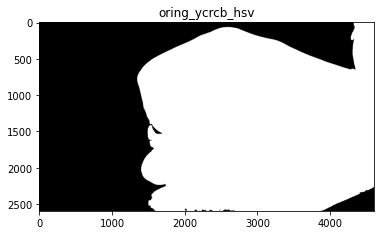

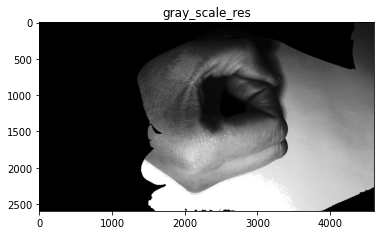

In [7]:
oring_ycrcb_hsv = cv.bitwise_or(largest_contour_image, largest_contour_image_ycrcb)
show_images([oring_ycrcb_hsv], ["oring_ycrcb_hsv"])

gray_scale_res = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray_scale_res[oring_ycrcb_hsv == 0] = 0
gray_scale_res = cv.equalizeHist(gray_scale_res)

show_images([gray_scale_res],[ "gray_scale_res"])


## Solution using histogram equalization (Best)

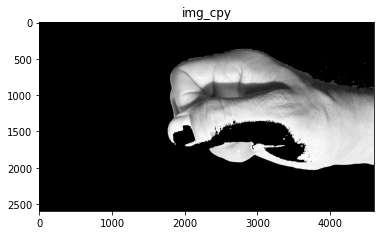

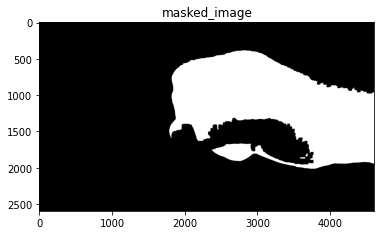

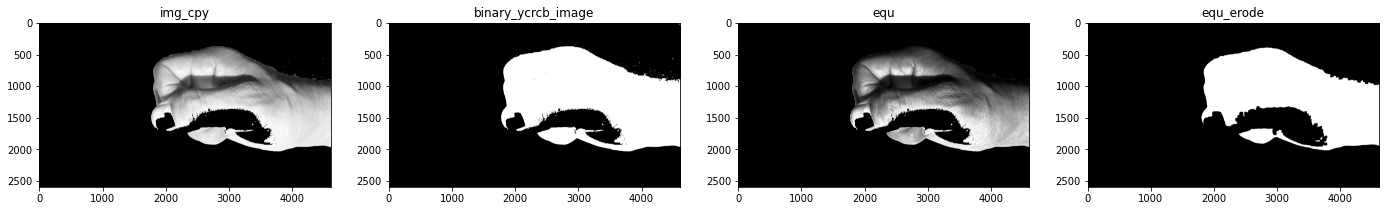

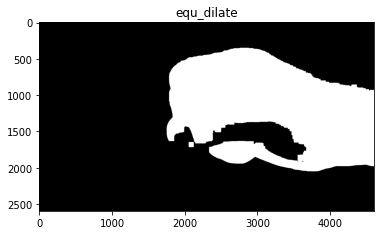

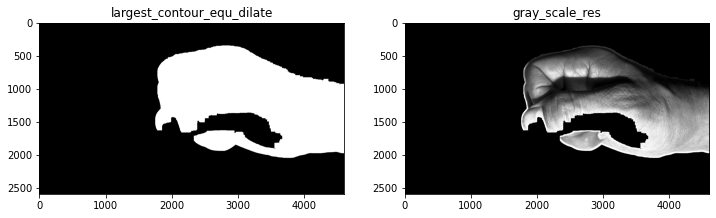

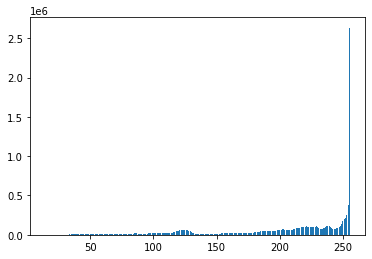

In [117]:
img = cv.imread('../Dataset_0-5/men/0/0_men (1).JPG')


# Convert the input image to YCrCb color space
ycrcb_image = cv.cvtColor(img, cv.COLOR_BGR2YCrCb)


# Define the lower and upper bounds of the skin color in YCrCb color space
lower_skin = np.array((0, 133, 77))
upper_skin = np.array((255, 173, 127))

# Apply the color segmentation using cv2.inRange()
binary_ycrcb_image = cv.inRange(ycrcb_image, lower_skin, upper_skin)

img_cpy_original = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_cpy = img_cpy_original.copy()
img_cpy[binary_ycrcb_image == 0] = 0

show_images([img_cpy], ["img_cpy"])

# Perform histogram equalization
equ = cv.equalizeHist(img_cpy)

kernel = np.ones((10, 10), np.uint8)
equ_erode = cv.erode(img_cpy, kernel, iterations=4)

equ_erode = fill_holes(equ_erode)

_, masked_image = cv.threshold(equ_erode, 0, 255, cv.THRESH_OTSU)
masked_image = fill_holes(masked_image)
show_images([masked_image], ["masked_image"])

equ_dilate = fill_holes(masked_image)
kernel = np.ones((15, 15), np.uint8)
equ_dilate = cv.dilate(equ_dilate, kernel, iterations=5)


show_images([img_cpy, binary_ycrcb_image, equ, equ_erode], ["img_cpy", "binary_ycrcb_image", "equ", "equ_erode"])
show_images([equ_dilate],["equ_dilate"])


contours, hierarchy = cv2.findContours(
    equ_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# # Get the contour with the largest area
largest_contour = max(contours, key=cv.contourArea)

# Create a blank image to draw and fill the contours
largest_contour_equ_dilate = np.zeros_like(img_cpy)
# Draw the largest contour on the image
cv.drawContours(largest_contour_equ_dilate, [
                largest_contour], 0, (255, 255), -1)

gray_scale_res = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray_scale_res[largest_contour_equ_dilate == 0] = 0
gray_scale_res = cv.equalizeHist(gray_scale_res)

show_images([largest_contour_equ_dilate, gray_scale_res],
            ["largest_contour_equ_dilate", "gray_scale_res"])


showHist(img_cpy_original)


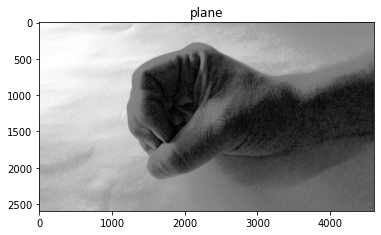

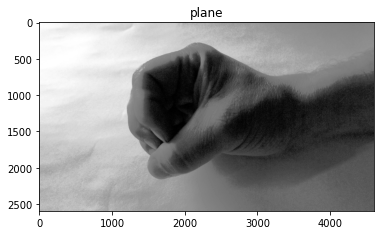

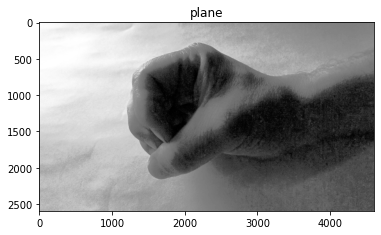

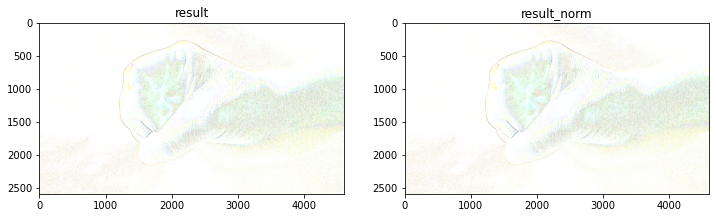

In [9]:
img = cv.imread('../Dataset_0-5/men/0/0_men (137).JPG')

rgb_planes = cv2.split(img)

result_planes = []
result_norm_planes = []
for plane in rgb_planes:
    plane = cv.equalizeHist(plane)
    show_images([plane], ["plane"])
    dilated_img = cv2.dilate(plane, np.ones((7, 7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 21)
    diff_img = 255 - cv2.absdiff(plane, bg_img)
    norm_img = cv2.normalize(
        diff_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    _, thr_img = cv2.threshold(norm_img, 230, 0, cv2.THRESH_TRUNC)
    norm_img = cv2.normalize(thr_img, thr_img, alpha=0, beta=255,
              norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    result_planes.append(thr_img)
    result_norm_planes.append(norm_img)

result = cv2.merge(result_planes)
result_norm = cv2.merge(result_norm_planes)

show_images([result, result_norm], ["result", "result_norm"])
